<a href="https://colab.research.google.com/github/toraaglobal/SREIT/blob/master/04_explore_and_modeling_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

## Import packages
from fbprophet import Prophet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
import datetime as dt
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [2]:
## OBTAIN


#Mount the gdrive
import os
from google.colab import drive
drive.mount('/content/drive')


#change directry to the gdrive

os.chdir('./drive/My Drive/Colab Notebooks/code')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
def read_csv(path):
  '''read data from path and return train and test set for prophet'''
  df = pd.read_csv(path)
  df = df.rename(index=str, columns={'RegionName': "Zipcode"})
  df['Date'] = pd.to_datetime(df['Date'])
  ## Data type convertion
  df['Zipcode'] = df['Zipcode'].astype(str)
  df['RegionID'] = df['RegionID'].astype(str)
  
  ## Training set : 1997 - 2017
  df_train = df[(df.Date.dt.year > 1996) & (df.Date.dt.year <= 2017) ]
  df_test = df[df.Date.dt.year == 2018]
  
  
  ## rename column for prophet model
  df_train = df_train.rename(index=str, columns={'Date':'ds', 'Values':'y'})
  df_test = df_test.rename(index=str, columns={'Date':'ds', 'Values':'y'})
  return df_train, df_test



train, test = read_csv('single_family_prep.csv')

print(train.info())
print(test.info())
  
  
  
  
  

<class 'pandas.core.frame.DataFrame'>
Index: 3901212 entries, 139329 to 4040540
Data columns (total 10 columns):
Unnamed: 0    int64
RegionID      object
Zipcode       object
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
ds            datetime64[ns]
y             float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 327.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 185772 entries, 4040541 to 4226312
Data columns (total 10 columns):
Unnamed: 0    185772 non-null int64
RegionID      185772 non-null object
Zipcode       185772 non-null object
City          185772 non-null object
State         185772 non-null object
Metro         169488 non-null object
CountyName    185772 non-null object
SizeRank      185772 non-null int64
ds            185772 non-null datetime64[ns]
y             185772 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 15.6+ MB
None


In [4]:
## print train data
train.head()

,Unnamed: 0,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ds,y
139329,139329,60657,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,1997-01-01,344900.0
139330,139330,77494,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,1997-01-01,197300.0
139331,139331,60614,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,1997-01-01,503200.0
139332,139332,77449,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1997-01-01,96600.0
139333,139333,79936,79936,El Paso,TX,El Paso,El Paso County,5,1997-01-01,77800.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.724302e+06, 6.173000e+03, 4.600000e+02, 1.790000e+02,
        1.020000e+02, 1.020000e+02, 5.100000e+01, 1.100000e+01,
        6.000000e+00, 3.000000e+01]),
 array([1.230000e+04, 1.944880e+06, 3.877460e+06, 5.810040e+06,
        7.742620e+06, 9.675200e+06, 1.160778e+07, 1.354036e+07,
        1.547294e+07, 1.740552e+07, 1.933810e+07]),
 <a list of 10 Patch objects>)

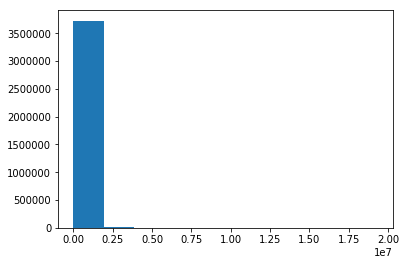

In [5]:
## Relationship between the sizerank and mean housing values

plt.hist(train.y)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.781000e+03, 1.250600e+05, 1.100919e+06, 1.568507e+06,
        7.036730e+05, 1.958840e+05, 2.791600e+04, 4.975000e+03,
        4.760000e+02, 2.250000e+02]),
 array([ 9.41735454, 10.15337787, 10.88940119, 11.62542452, 12.36144785,
        13.09747117, 13.8334945 , 14.56951782, 15.30554115, 16.04156448,
        16.7775878 ]),
 <a list of 10 Patch objects>)

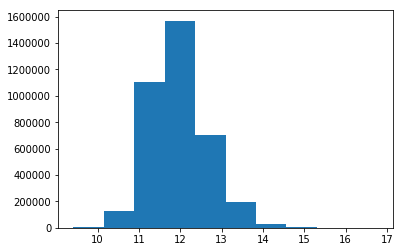

In [6]:
## log distribution

plt.hist(np.log(train.y))

In [7]:
train['log_values'] = np.log(train['y'].values)

train.head()

,Unnamed: 0,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ds,y,log_values
139329,139329,60657,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,1997-01-01,344900.0,12.751010
139330,139330,77494,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,1997-01-01,197300.0,12.192481
139331,139331,60614,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,1997-01-01,503200.0,13.128743
139332,139332,77449,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1997-01-01,96600.0,11.478334
139333,139333,79936,79936,El Paso,TX,El Paso,El Paso County,5,1997-01-01,77800.0,11.261897


In [8]:
test['log_values'] = np.log(test['y'].values)
test.head()

,Unnamed: 0,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ds,y,log_values
4040541,4040541,60657,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,2018-01-01,1028300.0,13.843418
4040542,4040542,77494,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,2018-01-01,322600.0,12.684168
4040543,4040543,60614,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,2018-01-01,1309300.0,14.085003
4040544,4040544,77449,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,2018-01-01,173500.0,12.063933
4040545,4040545,79936,79936,El Paso,TX,El Paso,El Paso County,5,2018-01-01,120200.0,11.696912


In [9]:
## rename columns for prophet
train = train.rename(index=str, columns={'y': 'Values', 'log_values': 'y'})
test = test.rename(index=str, columns={'y': 'Values', 'log_values': 'y'})
train.head()


,Unnamed: 0,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ds,Values,y
139329,139329,60657,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,1997-01-01,344900.0,12.751010
139330,139330,77494,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,1997-01-01,197300.0,12.192481
139331,139331,60614,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,1997-01-01,503200.0,13.128743
139332,139332,77449,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1997-01-01,96600.0,11.478334
139333,139333,79936,79936,El Paso,TX,El Paso,El Paso County,5,1997-01-01,77800.0,11.261897


In [10]:
test.head()

,Unnamed: 0,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ds,Values,y
4040541,4040541,60657,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,2018-01-01,1028300.0,13.843418
4040542,4040542,77494,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,2018-01-01,322600.0,12.684168
4040543,4040543,60614,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,2018-01-01,1309300.0,14.085003
4040544,4040544,77449,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,2018-01-01,173500.0,12.063933
4040545,4040545,79936,79936,El Paso,TX,El Paso,El Paso County,5,2018-01-01,120200.0,11.696912


In [0]:
train.to_csv('single_family_train.csv')
test.to_csv('single_family_test.csv')

In [0]:

## create a database connection
conn = sqlite3.connect('uszipmodel.sqlite')
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS models_log (zip TEXT NOT NULL UNIQUE, model BLOB, mse REAL )''')
conn.commit()

In [0]:
def run_zip_model(df, zipcode, df_test):
  # initialize the model
  model = Prophet(interval_width=0.95)
  #check if Zipmodel already in database
  cur.execute("SELECT mse from models_log where zip = ?",(zipcode,))
  try:
    data = cur.fetchone()[0]
    #print("Model found in database")
  except:
    model.fit(df)
    
    #future_dates = df_test['ds']
    #print(future_dates.head())
    
    forecast = model.predict(df_test)
    #print(forecast.head())
    #actual
    y_actual = df_test['y']
    y_predict = forecast['yhat']
    #score
    score = round( mean_squared_error(y_actual, y_predict),6)
    print(score)
    cur.execute('''INSERT INTO models_log (zip,model,mse)
    VALUES (?,?,?)''',(zipcode,pickle.dumps(model),score))
    
    conn.commit()

In [14]:
## get all zipcode in a list

zips = train['Zipcode'].unique()

zips = list(zips)

len(zips)

15481

In [0]:
#count = 0
#for zip in zips:
#  train_df = train[train['Zipcode'] == zip]
#  test_df = test[test['Zipcode']== zip]
#  run_zip_model(train_df, zip, test_df)
#  count+=1
#  print("Counts: {}".format(count))
#  conn.commit()

In [16]:
cur.execute("SELECT COUNT(model) FROM models_log")
for _ in cur:
  print(_)


(15481,)
